In [1]:
updated_path = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/'

In [2]:
old_path = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/tifs/"
old_json = "/Mounts/rbg-storage1/datasets/PLCO_XRAY/metadata_2022_04_05_rotated.json"

In [3]:
from glob import glob
import json
import pandas as pd
import skimage
import numpy as np

In [4]:
im_names = [pth.replace('/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/', "") for pth in glob(updated_path + "*.tif")]

In [5]:
im_names[0]

'AH04082092107142739_v2.tif'

In [6]:
old_json = json.load(open(old_json, 'rb'))

In [7]:
old_im_names = []
for patient in old_json:
    for accession in patient['accessions']:
        for img_series in accession['image_series']:
            old_im_names.append(img_series['filename'])

In [20]:
old_json[0]

AttributeError: 'str' object has no attribute 'keys'

In [9]:
set_old_im_names = set(old_im_names)

In [10]:
len(set_old_im_names)

89716

In [11]:
trues = 0
falses = 0
for im_name in im_names:
    if im_name in set_old_im_names:
        trues += 1
    else:
        falses += 1

In [12]:
trues, falses

(89716, 108824)

In [13]:
patient2image = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv'

In [14]:
df = pd.read_csv(patient2image)[['image_file_name', 'plco_id']]

In [15]:
len(set(df['plco_id'].values))

25000

In [8]:
im_paths = glob(updated_path + "*.tif")

In [17]:
i = np.random.randint(0,198540)
path = im_paths[i]

In [18]:
path

'/Mounts/rbg-storage1/datasets/PLCO_XRAY/allxrays/AE04042120506081110_v2.tif'

In [4]:
from tqdm import tqdm
import albumentations as A
from skimage import exposure

In [10]:
height, width = (512, 512)
resize = A.Resize(height, width)

In [11]:
means = []
stds = []
for p in tqdm(im_paths[:len(im_paths)//100]):
    im = skimage.io.imread(p, plugin='tifffile')
    im = exposure.rescale_intensity(im, in_range='uint12').astype(np.float64)
    out = resize(image=im)['image']
    means.append(np.mean(out))
    stds.append(np.std(out))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1985/1985 [03:37<00:00,  9.12it/s]


In [12]:
np.mean(means), np.mean(stds)

(45819.16578367201, 14211.166097275762)

In [ ]:
(2863.070033296751, 887.966694489157)

In [27]:
equalize = A.Equalize(always_apply=True)

In [118]:
means = []
stds = []
for p in tqdm(im_paths[:len(im_paths)//100]):
    im = skimage.io.imread(p, plugin='tifffile')
    im = resize(image=im)['image']
    im8 = im.astype(np.uint8)
    out = equalize(image=im.astype(np.uint8))['image']
    means.append(np.mean(out))
    stds.append(np.std(out))
    break

 78%|███████████████████████████████████████████████████████████████████████████████████▌                       | 1551/1985 [02:04<00:34, 12.45it/s]


KeyboardInterrupt: 

In [110]:
from skimage.util import img_as_ubyte

In [112]:
im

array([[   0,    0,    0, ..., 3848, 3848, 3848],
       [   0,    0,    0, ..., 3848, 3848, 3848],
       [   0,    0,    0, ..., 3848, 3848, 3848],
       ...,
       [3837, 3848, 3848, ..., 3848, 3848, 3848],
       [3837, 3848, 3848, ..., 3848, 3848, 3848],
       [3837, 3848, 3848, ..., 3848, 3848, 3848]], dtype=uint16)

In [113]:
image = exposure.rescale_intensity(im, in_range='uint12')

In [115]:
image.astype(np.float64)

array([[    0.,     0.,     0., ..., 61582., 61582., 61582.],
       [    0.,     0.,     0., ..., 61582., 61582., 61582.],
       [    0.,     0.,     0., ..., 61582., 61582., 61582.],
       ...,
       [61406., 61582., 61582., ..., 61582., 61582., 61582.],
       [61406., 61582., 61582., ..., 61582., 61582., 61582.],
       [61406., 61582., 61582., ..., 61582., 61582., 61582.]])

In [75]:
import matplotlib.pyplot as plt

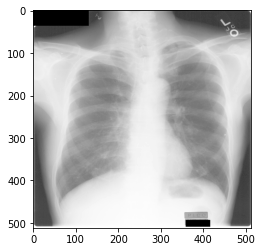

In [76]:
plt.imshow(im, cmap='gray')

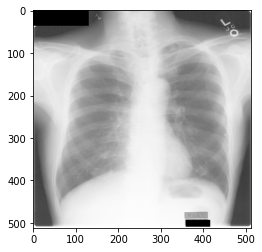

In [79]:
plt.imshow(image, cmap='gray')

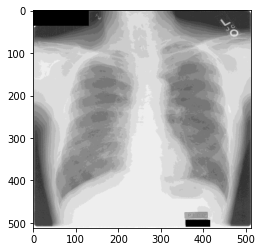

In [97]:
plt.imshow(img_as_ubyte(im), cmap='gray')

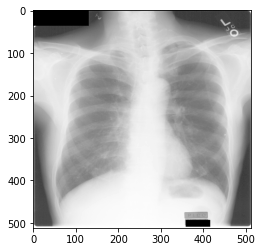

In [98]:
plt.imshow(img_as_ubyte(image), cmap='gray')

In [101]:
len(set(img_as_ubyte(image).reshape(-1).tolist()))

195

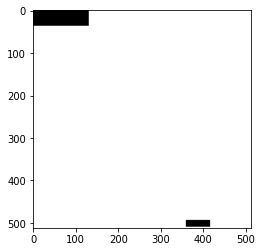

In [62]:
plt.imshow(image, cmap='gray')

In [30]:
np.mean(means), np.mean(stds)

(124.70010375976562, 75.47953517405743)

In [13]:
patient2image = '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv'

In [14]:
files = glob('/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/*/*.csv')

In [15]:
files

['/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Screens (image only)/lung_screen.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Diagnostic Procedures/lung_proc_data_nov18_d070819.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Treatments/lung_trt_data_nov18_d070819.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Screening Abnormalities/lung_scrsub_data_nov18_d070819.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Person (image only)/lung_prsn.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv',
 '/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Medical Complications/lung_med_data_nov18_d070819.csv']

In [16]:
for file in files:
    df = pd.read_csv(file)
    print(file)
    print(len(set(df[['plco_id']].values.reshape(-1).tolist())))

/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Screens (image only)/lung_screen.csv
70632
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Diagnostic Procedures/lung_proc_data_nov18_d070819.csv
15081
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Treatments/lung_trt_data_nov18_d070819.csv
3229
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Screening Abnormalities/lung_scrsub_data_nov18_d070819.csv
44592
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Lung Person (image only)/lung_prsn.csv
154887
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Standard 25K Linkage (2021)/link_2021_25k_selection.csv
25000
/Mounts/rbg-storage1/datasets/PLCO_XRAY/package-plcoi-919/Lung/Medical Complications/lung_med_data_nov18_d070819.csv
962


In [ ]:
df.head()

In [23]:
old_metadata = json.load(open(old_json, 'rb'))

In [26]:
old_pids = []
for patient in old_metadata:
    old_pids.append(patient['pid'])

In [27]:
len(old_pids)

25000